# ОИАД. Лабораторная работа №2

## Входные данные
Датасет: **datasets/students_simple.csv**
Выбираются 2 слобкика данных по формулам:
1) N % 5
2) N^2 % 5 + 5
где $N$ - номер в списке

In [1]:
import pandas as pd

path = "../datasets/students_simple.csv"
df = pd.read_csv(path)

N = 10
col1 = df.columns[N % 5]
col2 = df.columns[N*N % 5 + 5]
print(col1, col2)

height age


## 1. Расчет корреляций

### 1) [Коэффициент Фехнера](https://www.analystsoft.com/en/products/statplus/content/help/pdf/analysis_basic_statistics_fechner_correlation.pdf)

**Идея и формула.**
Коэффициент Фехнера основан на сравнении знаков отклонений каждого наблюдения от соответствующих средних. Для каждой записи i берем знаки `sign(x_i - x̄)` и `sign(y_i - ȳ)`. Обозначим

* $N_{+}$ - число наблюдений, где знаки совпадают (обе положительные или обе отрицательные),
* $N_{-}$ - число наблюдений, где знаки противоположны.

Тогда коэффициент Фехнера:

$F = \frac{N_{+} - N_{-}}{N_{+} + N_{-}}$

Диапазон: от −1 до +1. (Если все сравнения дают одинаковый знак → F = 1; противоположные - F = −1.)

Нули могут искажать счет, поэтому есть смысл их убрать.

Это непараметрическая мера согласованности направлений отклонений; она хорошо показывает, насколько данные "двигаются" в одно направление относительно своих средних.

### 2) [Пирсон + доверительный интервал](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D0%B8_%D0%9F%D0%B8%D1%80%D1%81%D0%BE%D0%BD%D0%B0)

Коэффициент корреляции Пирсона измеряет линейную взаимосвязь между двумя количественными переменными 𝑋 и 𝑌. Идея: оценить, насколько отклонения 𝑋 от своего среднего совпадают с отклонениями 𝑌 от своего среднего.

**Формула Пирсона:**

$
r = \frac{\sum_{i=1}^n (x_i - \bar x)(y_i - \bar y)}
{\sqrt{\sum_{i=1}^n (x_i - \bar x)^2};\sqrt{\sum_{i=1}^n (y_i - \bar y)^2}}.
$

Числитель - ковариация.
Знаменатель - произведение стандартных отклонений

Интерпретация: −1 (полная отрицательная линейная связь) … 0 (нет линейной) … +1 (полная положительная линейная).

**p-value:** проверка ($H_0: \rho=0$ (в генеральной совокупности нет линейной связи)) через t-статистику:
$
t = r\sqrt{\frac{n-2}{1-r^2}},
$
с распределением (t) с (n-2) степенями свободы.

**Доверительный интервал для r**
Проблема: распределение r несимметрично при r близких к ±1. Поэтому применяют преобразование Фишера:

$
z = \operatorname{arctanh}(r) = \tfrac{1}{2}\ln\frac{1+r}{1-r}.
$

$
z \pm z_{1-\alpha/2}\cdot \frac{1}{\sqrt{n-3}}.
$
z1−α/2 - квантиль стандартного нормального.

Потом обратное преобразование: ($r = \tanh(z)$).

-  Пирсон оценивает **линейную** связь и чувствителен к выбросам; для немонотонных зависимостей он может давать близкое к нулю значение даже при сильной связи.

### 3) [Спирмен](https://wiki.loginom.ru/articles/rank-correlation-spearman.html)

Спирмен - это коэффициент корреляции рангов. 
Проще всего думать так: замените исходные значения на их ранги по каждому признаку, а потом посчитайте корреляцию Пирсона между рангами. Если нет повторяющихся значений, существует простая формула
$
\rho = 1 - \frac{6\sum d_i^2}{n(n^2-1)},
$
где ($d_i$) - разность рангов для i-го наблюдения. Spearman оценивает **монотоническую** связь (не обязательно линейную).

### 4) [Кенделл](https://wiki.loginom.ru/articles/rank-correlation-kendall.html)

Основан на понятии *конкордантных* и *дисконкордантных* пар. Для всех пар (i<j) считаем:

* пара Concordant, если порядок по x совпадает с порядком по y (оба увеличиваются или уменьшаются),
* Discordant, если порядок противоположный.

Без учета ничьих:
$
\tau = \frac{n_c - n_d}{{n \choose 2}},
$
где $(n_c)$ - число конкорд., $(n_d)$ - число дисконкорд.
Есть несколько вариантов $(τ_a, τ_b, τ_c)$ - $τ_b$ корректирует влияние связанных рангов (ties). 

Kendall более «консервативен», чем Spearman; хорошо работает на небольших выборках и при наличии связей.

In [2]:
import math
import numpy as np
from scipy import stats


data = df[[col1, col2]].dropna()
x = data[col1].astype(float).to_numpy()
y = data[col2].astype(float).to_numpy()
n = len(x)


def sign_arr(a):
    return np.where(a > 0, 1, np.where(a < 0, -1, 0))

sx = sign_arr(x - x.mean())
sy = sign_arr(y - y.mean())
mask_nonzero = (sx != 0) & (sy != 0)
N_plus = np.sum((sx == sy) & mask_nonzero)
N_minus = np.sum((sx != sy) & mask_nonzero)
fechner = np.nan if (N_plus + N_minus) == 0 else (N_plus - N_minus) / (N_plus + N_minus)

r_pearson, p_pearson = stats.pearsonr(x, y)

def pearson_confidence_interval(r, n, alpha=0.05):
    # guard for r == +-1
    r = max(min(r, 0.9999999), -0.9999999)
    zr = np.arctanh(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)
    lo_z, hi_z = zr - z_crit*se, zr + z_crit*se
    return np.tanh(lo_z), np.tanh(hi_z)

pearson_ci = pearson_confidence_interval(r_pearson, n)

rho_spearman, p_spearman = stats.spearmanr(x, y)

tau_kendall, p_kendall = stats.kendalltau(x, y)

print(f"Fechner: F = {fechner:.4f}  (N+ = {N_plus}, N- = {N_minus})")
print(f"Pearson: r = {r_pearson:.4f}, p = {p_pearson:.4g}")
print(f"Pearson 95% CI (Fisher z): ({pearson_ci[0]:.4f}, {pearson_ci[1]:.4f})")
print(f"Spearman: p = {rho_spearman:.4f}, p = {p_spearman:.4g}")
print(f"Kendall: tau = {tau_kendall:.4f}, p = {p_kendall:.4g}")

Fechner: F = 0.1000  (N+ = 11, N- = 9)
Pearson: r = 0.1944, p = 0.4115
Pearson 95% CI (Fisher z): (-0.2715, 0.5865)
Spearman: p = 0.1750, p = 0.4605
Kendall: tau = 0.1223, p = 0.4698


## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)

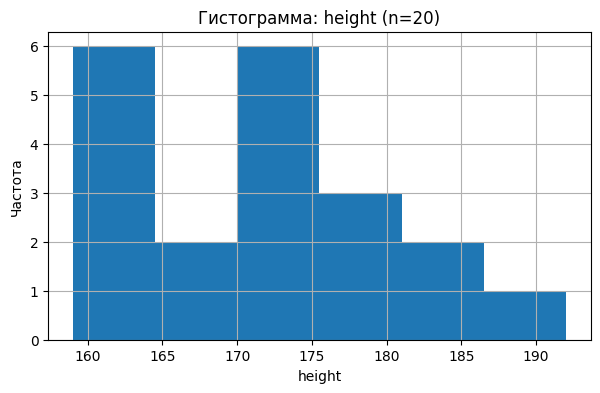

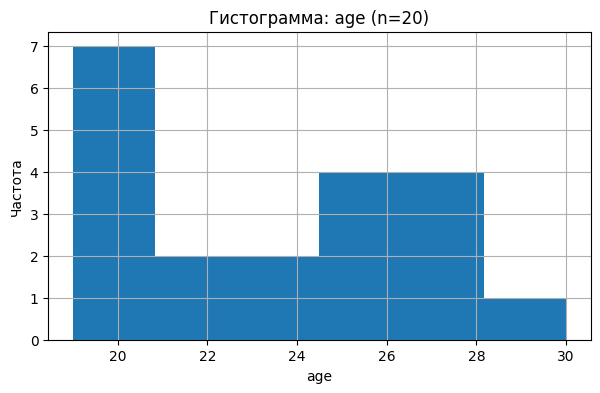

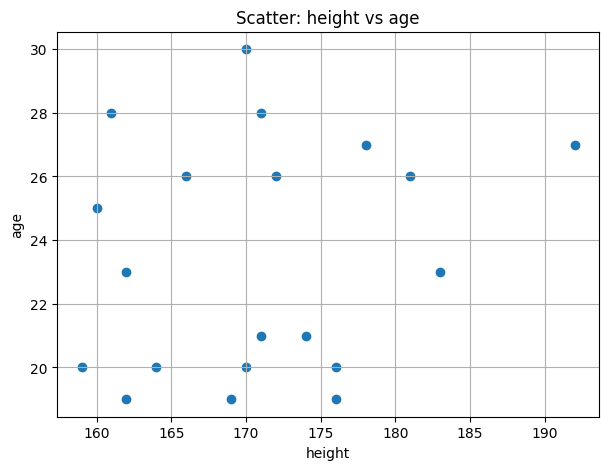

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


plt.figure(figsize=(7,4))
plt.hist(x, bins='auto')
plt.xlabel(col1)
plt.ylabel('Частота')
plt.title(f'Гистограмма: {col1} (n={len(x)})')
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.hist(y, bins='auto')
plt.xlabel(col2)
plt.ylabel('Частота')
plt.title(f'Гистограмма: {col2} (n={len(y)})')
plt.grid(True)
plt.show()

# Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(x, y)
plt.xlabel(col1)
plt.ylabel(col2)
plt.title(f'Scatter: {col1} vs {col2}')
plt.grid(True)
plt.show()


## 3. Уравнение регрессии

Регрессия - это способ построить модель, которая предсказывает зависимую переменную (y) через одну или несколько независимых переменных (x). Мы ищем функцию $(f(x; \mathbf{w}))$ с параметрами $(\mathbf{w})$, которая лучше всего объясняет наблюдаемые данные $((x_i,y_i))$.

* минимизируем сумму квадратов ошибок (OLS - ordinary least squares): $(\min_{\mathbf w}\sum_i (y_i - f(x_i;\mathbf w))^2)$.
* Результат - набор коэффициентов. Они дают формулу регрессии, по которой можно предсказывать (y) для новых (x).


Построить уравнение регрессии по видам:

1. **Линейная** $(y = w_1 x + w_0)$
   самая простая; сводится к линейной регрессии по параметрам ($w_1,w_0$).
   Минимизируем $(\sum (y_i - w_1 x_i - w_0)^2)$

2. **Квадратичная** $(y = w_2 x^2 + w_1 x + w_0)$
   Тоже линейная по параметрам (w_2,w_1,w_0)

3. **Гиперболическая** $(y = \dfrac{w_1}{x} + w_0)$
   модель линейна по параметрам, если ввести новый признак $(z = 1/x)$: тогда $(y = w_1 z + w_0)$. Поэтому подгонка - обычный OLS, но надо удалить или обработать точки с (x=0) (деление на ноль).

4. **Показательная** $(y = w_0 \cdot w_1^x)$
   Преобразование логарифмированием дает линейную форму:
   $
   \ln y = \ln w_0 + x \ln w_1.
   $
   Значит подгонка: сначала оставить только (y>0), взять $(Y=\ln y)$ и выполнить линейную регрессию $(Y = c_0 + c_1 x)$. Затем $(w_0 = e^{c_0},\ w_1 = e^{c_1})$

1) Линейная: y = w1*x + w0
   w1 = 0.082253, w0 = 9.347007
   R^2 = 0.037781

2) Квадратичная: y = w2*x^2 + w1*x + w0
   w2 = 0.005344, w1 = -1.771474, w0 = 169.689090
   R^2 = 0.055898

3) Гиперболическая: y = w1*(1/x) + w0  (строки с x==0 исключены из подгонки)
   w1 = -2351.711253, w0 = 37.197016
   R^2 (на 20 точках) = 0.034683

4) Показательная: y = w0 * w1^x
   w0 = 12.475464, w1 = 1.003621
   R^2 (на 20 точках = 0.033619



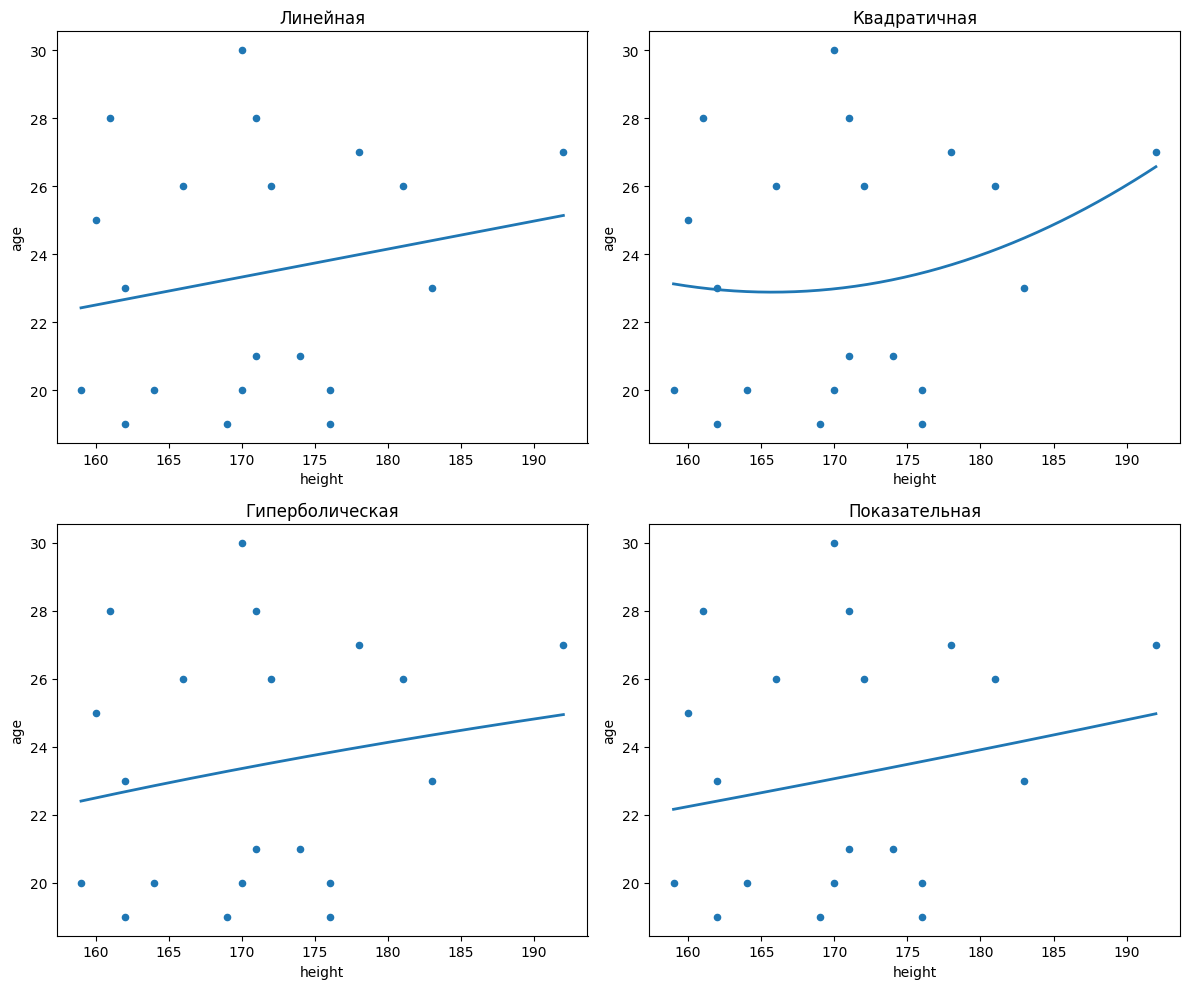

In [4]:
def rsq(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot != 0 else float('nan')

def fit_linear(x, y):
    X = np.column_stack((x, np.ones_like(x)))
    w, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_pred = X.dot(w)
    return w, y_pred

def fit_quadratic(x, y):
    X = np.column_stack((x**2, x, np.ones_like(x)))
    w, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_pred = X.dot(w)
    return w, y_pred

def fit_hyperbolic(x, y):
    mask = x != 0
    if np.sum(mask) == 0:
        raise ValueError("Все x == 0, гипербола не определена")
    z = (1.0 / x[mask])
    X = np.column_stack((z, np.ones_like(z)))
    w, *_ = np.linalg.lstsq(X, y[mask], rcond=None)
    y_pred = np.full_like(y, np.nan, dtype=float)
    y_pred[mask] = X.dot(w)
    return w, y_pred, mask

def fit_exponential(x, y):
    mask = y > 0
    if np.sum(mask) < 2:
        raise ValueError("Недостаточно положительных y для экспоненциальной модели")
    t = np.log(y[mask])
    X = np.column_stack((x[mask], np.ones_like(x[mask])))
    
    ab, *_ = np.linalg.lstsq(X, t, rcond=None)
    a, b = ab[0], ab[1]
    w1 = math.exp(a)
    w0 = math.exp(b)
    
    y_pred = w0 * (w1 ** x)
    
    return (w0, w1), y_pred, mask

w_lin, yhat_lin = fit_linear(x, y)
w_quad, yhat_quad = fit_quadratic(x, y)
w_hyp, yhat_hyp, mask_hyp = fit_hyperbolic(x, y)
(w0_exp, w1_exp), yhat_exp, mask_exp = fit_exponential(x, y)

print("1) Линейная: y = w1*x + w0")
print(f"   w1 = {w_lin[0]:.6f}, w0 = {w_lin[1]:.6f}")
print(f"   R^2 = {rsq(y, yhat_lin):.6f}\n")

print("2) Квадратичная: y = w2*x^2 + w1*x + w0")
print(f"   w2 = {w_quad[0]:.6f}, w1 = {w_quad[1]:.6f}, w0 = {w_quad[2]:.6f}")
print(f"   R^2 = {rsq(y, yhat_quad):.6f}\n")

print("3) Гиперболическая: y = w1*(1/x) + w0  (строки с x==0 исключены из подгонки)")
print(f"   w1 = {w_hyp[0]:.6f}, w0 = {w_hyp[1]:.6f}")
print(f"   R^2 (на {np.sum(mask_hyp)} точках) = {rsq(y[mask_hyp], yhat_hyp[mask_hyp]):.6f}\n")

print("4) Показательная: y = w0 * w1^x")
print(f"   w0 = {w0_exp:.6f}, w1 = {w1_exp:.6f}")
print(f"   R^2 (на {np.sum(mask_exp)} точках = {rsq(y[mask_exp], yhat_exp[mask_exp]):.6f}\n")
 
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

axes[0].scatter(x, y, s=20)
axes[0].plot(np.sort(x), yhat_lin[np.argsort(x)], linewidth=2)
axes[0].set_title("Линейная")
axes[0].set_xlabel(col1); axes[0].set_ylabel(col2)

axes[1].scatter(x, y, s=20)
xs = np.linspace(np.min(x), np.max(x), 200)
yquad_line = w_quad[0]*xs**2 + w_quad[1]*xs + w_quad[2]
axes[1].plot(xs, yquad_line, linewidth=2)
axes[1].set_title("Квадратичная")
axes[1].set_xlabel(col1); axes[1].set_ylabel(col2)

axes[2].scatter(x, y, s=20)
xs_h = xs[xs != 0]
yhy_line = w_hyp[0]*(1.0/xs_h) + w_hyp[1]
axes[2].plot(xs_h, yhy_line, linewidth=2)
axes[2].set_title("Гиперболическая")
axes[2].set_xlabel(col1); axes[2].set_ylabel(col2)

axes[3].scatter(x, y, s=20)
yexp_line = w0_exp * (w1_exp ** xs)
axes[3].plot(xs, yexp_line, linewidth=2)
axes[3].set_title("Показательная")
axes[3].set_xlabel(col1); axes[3].set_ylabel(col2)

plt.tight_layout()
plt.show()

## 4. Проверка уравнения регрессии 


### [Fisher](https://en.wikipedia.org/wiki/F-test) 

Для наилучшего и наихудшего уравнения регрессии проверить соотвествие модели данных с помощью критерия Фишера.


Объясняет ли наша модель зависимость y лучше, чем просто усредненное значение $(\bar y)$?

* Нулевая гипотеза (H_0): модель не лучше, чем константа
* Альтернатива (H_1): модель объясняет значительную часть вариации y

F-тест сравнивает **объясненную дисперсию** (насколько модель сдвигает предсказания от среднего) с **необъясненной (остаточной) дисперсией**. Если отношение (корректированное на число параметров) велико - модель значима.


Обозначения:

* (n) — число наблюдений (в модели, на которых проводили подгонку).
* (k) — число параметров модели (включая свободный член). Примеры: линейная (k=2) (w1, w0), квадратичная (k=3), и т.д.
* $(y_i)$ — наблюдаемое значение,
* $(\hat y_i)$ — предсказанное моделью,
* $(\bar y = \frac{1}{n}\sum_i y_i)$.

Суммы квадратов:

* $(SS_{tot} = \sum_{i=1}^n (y_i - \bar y)^2)$ — полная сумма квадратов (общая вариация).
* $(SS_{res} = \sum_{i=1}^n (y_i - \hat y_i)^2)$ — остаточная сумма квадратов (необъясненная вариация).
* $(SS_{reg} = SS_{tot} - SS_{res} = \sum (\hat y_i - \bar y)^2)$ — объясненная моделью вариация.

Степени свободы:

* $(df_{reg} = k - 1)$
* $(df_{res} = n - k)$

F-статистика:
$
F = \frac{SS_{reg} / df_{reg}}{SS_{res} / df_{res}}.
$

Если (H_0) истинна, то (F) имеет распределение $(F(df_{reg}, df_{res}))$. Мы сравниваем наблюдаемое (F) с критическим значением $(F_{crit})$ при заданном $(\alpha)$ (обычно 0.05), или вычисляем p-value: $(p = 1 - F_{cdf}(F))$ (или `stats.f.sf(F, df_reg, df_res)` в scipy).

Крайние случаи:

* Если $(SS_{res} = 0) $(идеальная подгонка) → $(F=\infty)$ и p≈0 — модель "полностью" объясняет y.
* Если $(SS_{tot} = 0)$ (все y равны) → тест не определен (нет вариации).


In [5]:
def fisher_f_test(y_true, y_pred, k, alpha=0.05):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
 
    n = y_true.size
  
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean)**2)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_reg = ss_tot - ss_res

    df_reg = k - 1
    df_res = n - k

    ms_reg = ss_reg / df_reg
    ms_res = ss_res / df_res
    F = ms_reg / ms_res
    p = stats.f.sf(F, df_reg, df_res)  

    F_crit = stats.f.ppf(1 - alpha, df_reg, df_res)
    return {"F": F, "p_value": p,
            "ss_reg": ss_reg, "ss_res": ss_res, "ss_tot": ss_tot,
            "df_reg": df_reg, "df_res": df_res, "F_crit": F_crit}

def interpret_f_result(res, alpha=0.05):
    s = []
    s.append(f"F = { res["F"]:.4g}, df_reg = {res["df_reg"]}, df_res = {res["df_res"]}")
    s.append(f"p-value = {res["p_value"]:.4g}, критическое F (alpha={alpha}) = {res["F_crit"]:.4g}")

    if res["p_value"] < alpha:
        s.append("Результат статистически значим: отвергаем H0 — модель объясняет значимую долю вариации y.")
    else:
        s.append("Результат не значим: нет оснований считать, что модель лучше константы.")
 
    return "\n".join(s)

# 1) Линейная
res_lin = fisher_f_test(y, yhat_lin, k=2)
print("Линейная модель:")
print(interpret_f_result(res_lin))

# 2) Квадратичная
res_quad = fisher_f_test(y, yhat_quad, k=3)
print("\nКвадратичная модель:")
print(interpret_f_result(res_quad))

# 3) Гиперболическая
res_hyp = fisher_f_test(y[mask_hyp], yhat_hyp[mask_hyp], k=2)
print("\nГиперболическая модель:")
print(interpret_f_result(res_hyp))

# 4) Экспоненциальная
res_exp_orig = fisher_f_test(y[mask_exp], yhat_exp[mask_exp], k=2)
print("\nЭкспоненциальная модель:")
print(interpret_f_result(res_exp_orig))


Линейная модель:
F = 0.7068, df_reg = 1, df_res = 18
p-value = 0.4115, критическое F (alpha=0.05) = 4.414
Результат не значим: нет оснований считать, что модель лучше константы.

Квадратичная модель:
F = 0.5033, df_reg = 2, df_res = 17
p-value = 0.6133, критическое F (alpha=0.05) = 3.592
Результат не значим: нет оснований считать, что модель лучше константы.

Гиперболическая модель:
F = 0.6467, df_reg = 1, df_res = 18
p-value = 0.4318, критическое F (alpha=0.05) = 4.414
Результат не значим: нет оснований считать, что модель лучше константы.

Экспоненциальная модель:
F = 0.6262, df_reg = 1, df_res = 18
p-value = 0.4391, критическое F (alpha=0.05) = 4.414
Результат не значим: нет оснований считать, что модель лучше константы.
